<a href="https://colab.research.google.com/github/mandyamavinash/Mandyam_Avinash_Public/blob/main/2025AB05238_cnn_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

## STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: [2025AB05238]

Name: [MANDYAM AVINASH]

Email: [2025AB05238@WILP.BITS-PILANI.AC.IN]

Date: [Submission date]

In [26]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import time
import json
import os

In [27]:
# Deep learning frameworks (choose Keras or PyTorch)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# For image processing
from PIL import Image
import cv2

### 1.1 Dataset Selection and Loading



In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d princelv84/dogsvscats

Dataset URL: https://www.kaggle.com/datasets/princelv84/dogsvscats
License(s): MIT
dogsvscats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogsvscats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [30]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='categorical',   # ✅ one-hot labels
    batch_size=32,
    image_size=(224,224),
    validation_split=0.1,
    subset="training",
    seed=123
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='categorical',   # ✅ one-hot labels
    batch_size=32,
    image_size=(224,224),
    validation_split=0.1,
    subset="validation",
    seed=123
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.
Found 5000 files belonging to 2 classes.
Using 500 files for validation.


In [31]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats vs Dogs"
dataset_source = "https://www.kaggle.com/datasets/princelv84/dogsvscats"
n_samples = 20000  # TODO: Total number of images
n_classes = 2  # TODO: Number of classes
samples_per_class = "9000"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

In [32]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """
TODO: Write 1-2 sentences explaining your metric choice.
"""

In [33]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: https://www.kaggle.com/datasets/princelv84/dogsvscats
Total Samples: 20000
Number of Classes: 2
Samples per Class: 9000
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
TODO: Write 1-2 sentences explaining your metric choice.



### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

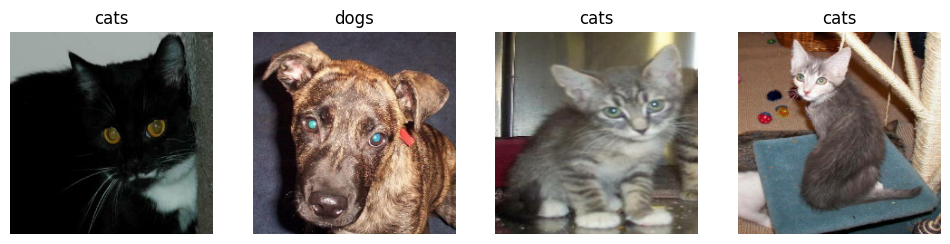

In [34]:
# Show a few samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, (images, labels) in enumerate(train_ds.take(4)):
    # Take the first image from the batch
    image = images[0].numpy()
    label = labels[0].numpy()

    # ✅ Convert one-hot label to integer class index
    class_idx = np.argmax(label)   # 0 = cat, 1 = dog

    axes[i].imshow(image.astype("uint8"))  # ensure proper dtype
    axes[i].set_title("cats" if class_idx == 0 else "dogs")
    axes[i].axis("off")

plt.show()

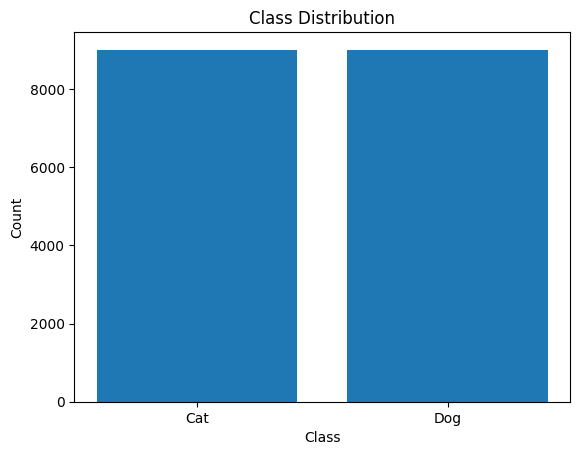

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Collect labels from dataset
labels = []
for _, batch_labels in train_ds:
    # Convert one-hot vectors to integer class indices
    labels.extend(np.argmax(batch_labels.numpy(), axis=1))

labels = np.array(labels)

# Count unique classes
unique, counts = np.unique(labels, return_counts=True)

# Plot distribution
plt.bar(unique, counts, tick_label=["Cat", "Dog"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [36]:
# Convert dataset to numpy arrays (sample subset for speed)
#images = [img.numpy() for img, _ in train_ds.take(1000)]  # sample 1000 images
#images = np.array(images)

#print("Image shape:", images[0].shape)
#print("Pixel mean:", np.mean(images))
#print("Pixel std:", np.std(images))
#print("Pixel min:", np.min(images))
#print("Pixel max:", np.max(images))

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [37]:
# Normalize
def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [38]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x), y))

# Shuffle + prefetch
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
# REQUIRED: Document your split
train_test_ratio = "90/10"
train_samples = 22500  # TODO: Number of training samples
test_samples = 2500  # TODO: Number of test samples

In [40]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 22500
Test Samples: 2500


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [41]:
def build_custom_cnn(input_shape=(224,224,3), n_classes=2):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 4 (extra depth)
    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(n_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    pass

In [42]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# TODO: Compile model
#custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function

In [44]:
custom_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,642 (1.74 MB)

 Trainable params: 455,682 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

### 2.2 Train Custom CNN

In [45]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',       # watch validation loss
    patience=5,               # stop if no improvement for 3 epochs
    restore_best_weights=True # roll back to the best model
)


CUSTOM CNN TRAINING


In [ ]:
# TODO: Train your model
history = custom_cnn.fit(train_ds,epochs=50,validation_data=validation_ds,callbacks=[early_stop])
# For PyTorch: write training loop

Epoch 1/50


In [ ]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [ ]:
# Initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]
custom_cnn_final_loss = history.history['loss'][-1]

custom_cnn_initial_val_loss = history.history['val_loss'][0]
custom_cnn_final_val_loss   = history.history['val_loss'][-1]

In [ ]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

In [ ]:
print("\nCUSTOM CNN EVALUATION")

### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# Get predictions from your model on validation_ds
y_pred_probs = custom_cnn.predict(validation_ds)       # softmax probabilities
y_pred_int = np.argmax(y_pred_probs, axis=1)               # predicted class (0 or 1)

# Collect true labels from validation_ds
y_true = np.concatenate([labels.numpy() for _, labels in validation_ds], axis=0)

# Convert one-hot labels to integers
y_true_int = np.argmax(y_true, axis=1)

# Calculate metrics
custom_cnn_accuracy  = accuracy_score(y_true_int, y_pred_int)
custom_cnn_precision = precision_score(y_true_int, y_pred_int, average='macro')
custom_cnn_recall    = recall_score(y_true_int, y_pred_int, average='macro')
custom_cnn_f1        = f1_score(y_true_int, y_pred_int, average='macro')

In [ ]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Unbatch for individual samples
val_unbatched = validation_ds.unbatch()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, (image, label) in enumerate(val_unbatched.take(4)):
    pred_prob = custom_cnn.predict(image[None, ...])  # add batch dimension
    pred_class = np.argmax(pred_prob, axis=1)[0]

    axes[i].imshow(image.numpy().astype("uint8"))
    axes[i].set_title(f"True: {'Cat' if label.numpy()==0 else 'Dog'}\nPred: {'Cat' if pred_class==0 else 'Dog'}")
    axes[i].axis("off")

plt.show()

In [ ]:
for images, labels in validation_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("First 10 labels:", labels.numpy()[:10])

In [ ]:
pred_probs = custom_cnn.predict(images)
pred_classes = np.argmax(pred_probs, axis=1)

print("Predicted classes:", pred_classes[:10])
print("True labels:", labels.numpy()[:10])


In [ ]:

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(images[i].numpy().astype("uint8"))
    axes[i].set_title(f"True: {labels.numpy()[i]} | Pred: {pred_classes[i]}")
    axes[i].axis("off")
plt.show()


### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")

In [ ]:
# TODO: Choose and load pre-trained model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

pretrained_model_name = "ResNet50"

In [ ]:
def build_transfer_learning_model(base_model_name, input_shape=(224,224,3), n_classes=2):
  print("\n[3] Loading pre-trained ResNet50 model...")
  print("NOTE: ResNet50 is more memory-efficient than VGG16")
  print(f"      ResNet50: ~25M parameters vs VGG16: ~138M parameters")

  base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # Exclude the final classification layer
    input_shape=(224, 224, 3)
  )

  # Freeze base model layers (transfer learning)
  base_model.trainable = False

  print(f"Base model loaded: {len(base_model.layers)} layers")
  print(f"Base model trainable: {base_model.trainable}")
  print(f"Total base parameters: {base_model.count_params():,}")

  model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # MANDATORY: Replace Flatten
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
  ])

  # Compile model
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print("\nModel Architecture:")
  model.summary()

  print(f"\nTotal parameters: {model.count_params():,}")
  trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
  print(f"Trainable parameters: {trainable_params:,}")
  print(f"Frozen parameters: {model.count_params() - trainable_params:,}")


  return base_model

In [ ]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [ ]:
#Count layers and parameters
frozen_layers = sum([1 for layer in transfer_model.layers if not layer.trainable])
trainable_layers = sum([1 for layer in transfer_model.layers if layer.trainable])
total_parameters = transfer_model.count_params()
trainable_parameters = np.sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])

In [ ]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")

In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = tf.keras.optimizers.Adam(learning_rate=tl_learning_rate)

# Compile the model before training
transfer_model.compile(
    optimizer=tl_optimizer,
    loss="categorical_crossentropy",   # use categorical_crossentropy if n_classes > 2
    metrics=["accuracy"]
)


In [ ]:
# Track training time
tl_start_time = time.time()

In [ ]:
print("\n[5] Training transfer learning model...")
print("Using small batch size for memory efficiency...")

# Train with reduced batch size and subset of data for memory efficiency
history = transfer_model.fit(
    train_ds,
    batch_size=tl_batch_size,  # Small batch size for memory
    epochs=tl_epochs,       # Few epochs for demonstration
    validation_data=validation_ds,
    verbose=1
)

print("\nTraining completed!")


In [ ]:
tl_training_time = time.time() - tl_start_time

In [ ]:
# REQUIRED: Track initial and final loss
tl_initial_loss = 0.0  # TODO: Get from training history (first epoch)
tl_final_loss = 0.0  # TODO: Get from training history (last epoch)

In [ ]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# REQUIRED: Calculate all 4 metrics
tl_accuracy = 0.0  # TODO: accuracy_score(y_test, y_pred)
tl_precision = 0.0  # TODO: precision_score(y_test, y_pred, average='macro')
tl_recall = 0.0  # TODO: recall_score(y_test, y_pred, average='macro')
tl_f1 = 0.0  # TODO: f1_score(y_test, y_pred, average='macro')

In [ ]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 4.1 Metrics Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [ ]:
print(comparison_df.to_string(index=False))

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here